# Advanced Lane Finding Project

## Imports

In [1]:
import numpy as np
import cv2
import pickle
import glob
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

The number of inside corners in x and y

In [2]:
# Prepare object points
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

Find Corners

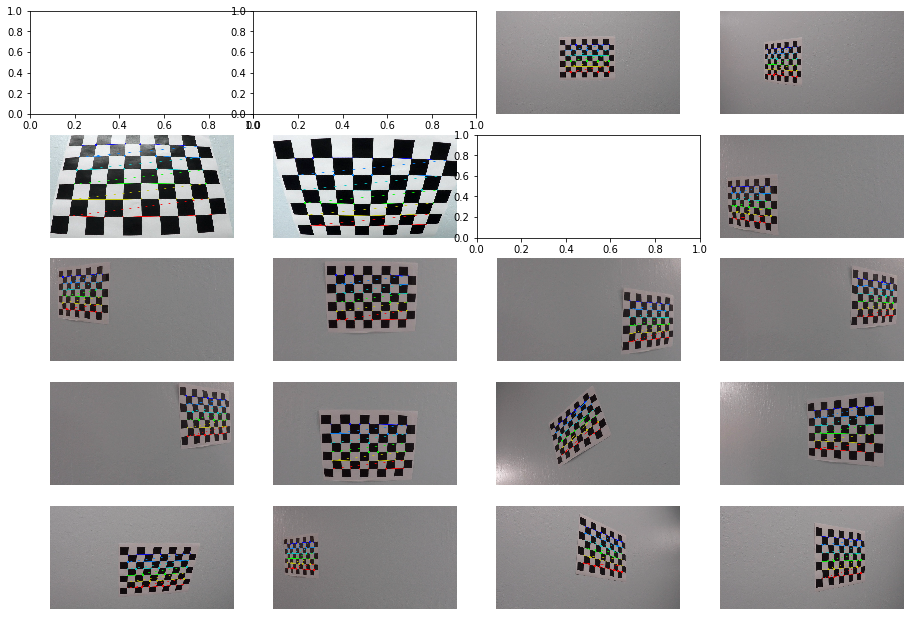

In [3]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

fig, axs = plt.subplots(5,4, figsize=(16, 11))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

# Step through the list and search for chessboard corners
for i, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)

        # this step to refine image points was taken from:
        # http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html
        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)
    
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        axs[i].axis('off')
        axs[i].imshow(img)

## Undistort and Transform Perspective
[undistort_and_transform.ipynb](https://github.com/jeongwhanchoi/find-chessboard-corners/blob/master/undistort_and_transform.ipynb)


Your goal is to generate output like the image shown above. To do that, you need to write a function that takes your distorted image as input and completes the following steps:
- Undistort the image using `cv2.undistort()` with mtx and dist
- Convert to grayscale
- Find the chessboard corners
- Draw corners
- Define 4 source points (the outer 4 corners detected in the chessboard pattern)
- Define 4 destination points (must be listed in the same order as src points!)
- Use `cv2.getPerspectiveTransform()` to get M, the transform matrix
- Use `cv2.warpPerspective()` to apply M and warp your image to a top-down view

In [4]:
# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
#pickle_path = './pickle/'
dist_pickle = pickle.load( open( "saved_cals.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Read in an image
path = './camera_cal/'
img = cv2.imread(path+'calibration8.jpg')
#nx = 8 # the number of inside corners in x
#ny = 6 # the number of inside corners in y

In [5]:
# MODIFY THIS FUNCTION TO GENERATE OUTPUT 
# THAT LOOKS LIKE THE IMAGE ABOVE
def corners_unwarp(img, nx, ny, mtx, dist):
    # Pass in your image into this function
    # Write code to do the following steps
    # 1) Undistort using mtx and dist
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # 2) Convert to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # 3) Find the chessboard corners 
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    # 4) If corners found: 
    if ret == True:
        # a) draw corners
        cv2.drawChessboardCorners(gray, (nx,ny), corners, ret)
        # offset for dst points
        offset = 100
        # grab the image shape
        img_size = (gray.shape[1], gray.shape[0])
        # b) define 4 source points src = np.float32([[,],[,],[,],[,]])
        #Note: you could pick any four of the detected corners 
        # as long as those four corners define a rectangle
        #One especially smart way to do this would be to use four well-chosen
        # corners that were automatically detected during the undistortion steps
        #We recommend using the automatic detection of corners in your code
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], [img_size[0]-offset, img_size[-1]-offset], [offset, img_size[-1]-offset]])
        # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # e) use cv2.warpPerspective() to warp your image to a top-down view
        warped = cv2.warpPerspective(undist, M, img_size)
    return warped, M

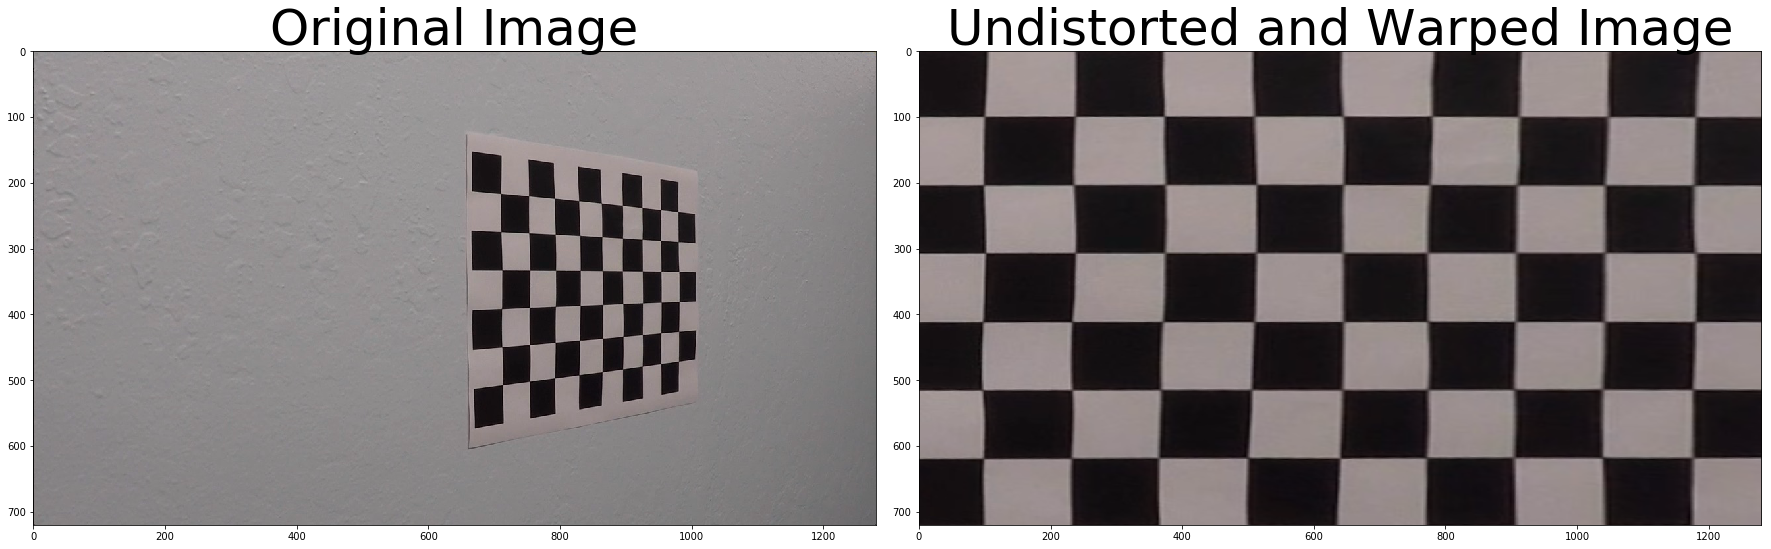

In [6]:
top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

---
## Pipeline

### Example Image

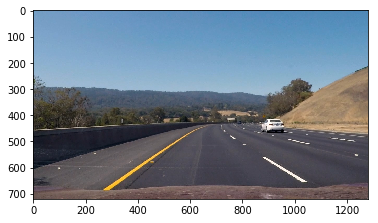

In [7]:
# Choose an image from which to build and demonstrate each step of the pipeline
exampleImg = cv2.imread('./test_images/test3.jpg')
exampleImg = cv2.cvtColor(exampleImg, cv2.COLOR_BGR2RGB)
plt.imshow(exampleImg)

### Undistort Image
- Undistort the image using cv2.undistort() with mtx and dist

In [8]:
# undistort image using camera calibration matrix from above
def undistort(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

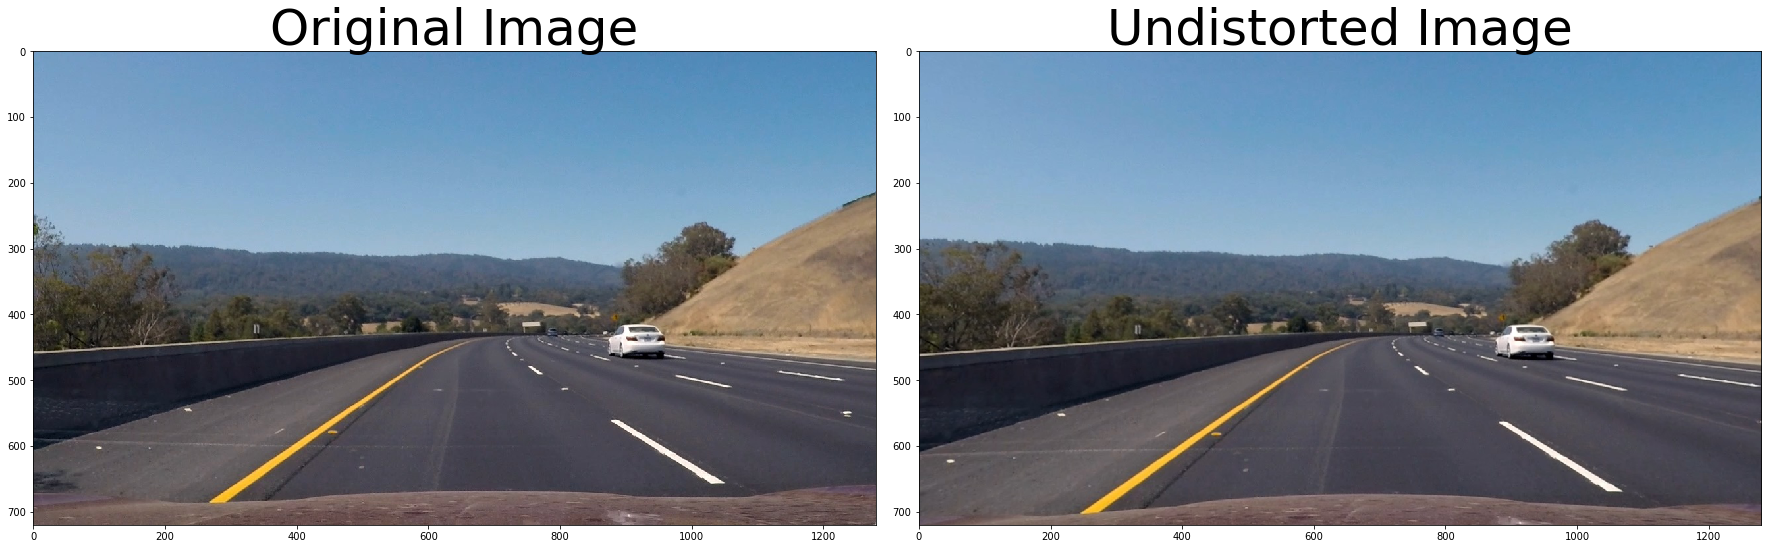

In [12]:
exampleImg_undistort = undistort(exampleImg)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,14))
# f.subplots_adjust(hspace = .2, wspace=.05)
f.tight_layout()
ax1.imshow(exampleImg)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(exampleImg_undistort)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Transform Perspective
- Use cv2.getPerspectiveTransform() to get M, the transform matrix
- Use cv2.warpPerspective() to apply M and warp your image to a top-down view

In [13]:
def unwarp(img, src, dst):
    h,w = img.shape[:2]
    # use cv2.getPerspectiveTransform() to get M, the transform matrix, and Minv, the inverse
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped, M, Minv

- Define 4 source points (the outer 4 corners detected in the chessboard pattern)
- Define 4 destination points (must be listed in the same order as src points!)

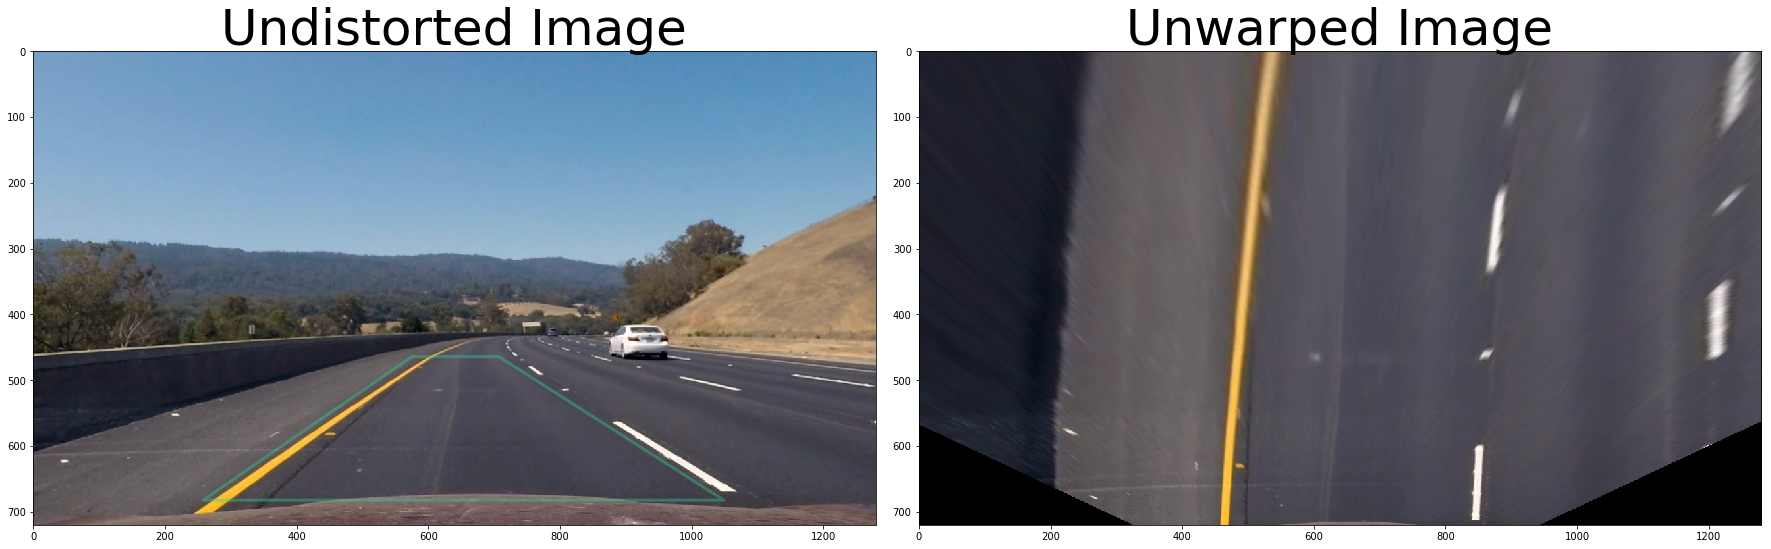

In [17]:
offset = 450
img_size = (exampleImg_undistort.shape[1], exampleImg_undistort.shape[0])
# h,w = exampleImg_undistort.shape[:2]

# define source and destination points for transform
src = np.float32([(575,464),
                  (707,464), 
                  (258,682), 
                  (1049,682)])
dst = np.float32([(offset,0),
                  (img_size[0]-offset,0),
                  (offset,img_size[-1]),
                  (img_size[0]-offset,img_size[-1])])

exampleImg_unwarp, M, Minv = unwarp(exampleImg_undistort, src, dst)

# Visualize unwarp
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,14))
f.tight_layout()
# f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(exampleImg_undistort)
x = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
y = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]
ax1.plot(x, y, color='#33cc99', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
# ax1.set_ylim([h,0])
# ax1.set_xlim([0,w])
ax1.set_title('Undistorted Image', fontsize=50)
ax2.imshow(exampleImg_unwarp)
ax2.set_title('Unwarped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Visualize multiple colorspace channels
- RGB
    - RGB R-Channel
    - RGB G-Channel
    - RGB B-Channel
- HSV
    - HSV H-Channel
    - HSV S-Channel
    - HSV V-Channel
- LAB
    - LAB L-Channel
    - LAB A-Channel
    - LAB B-Channel

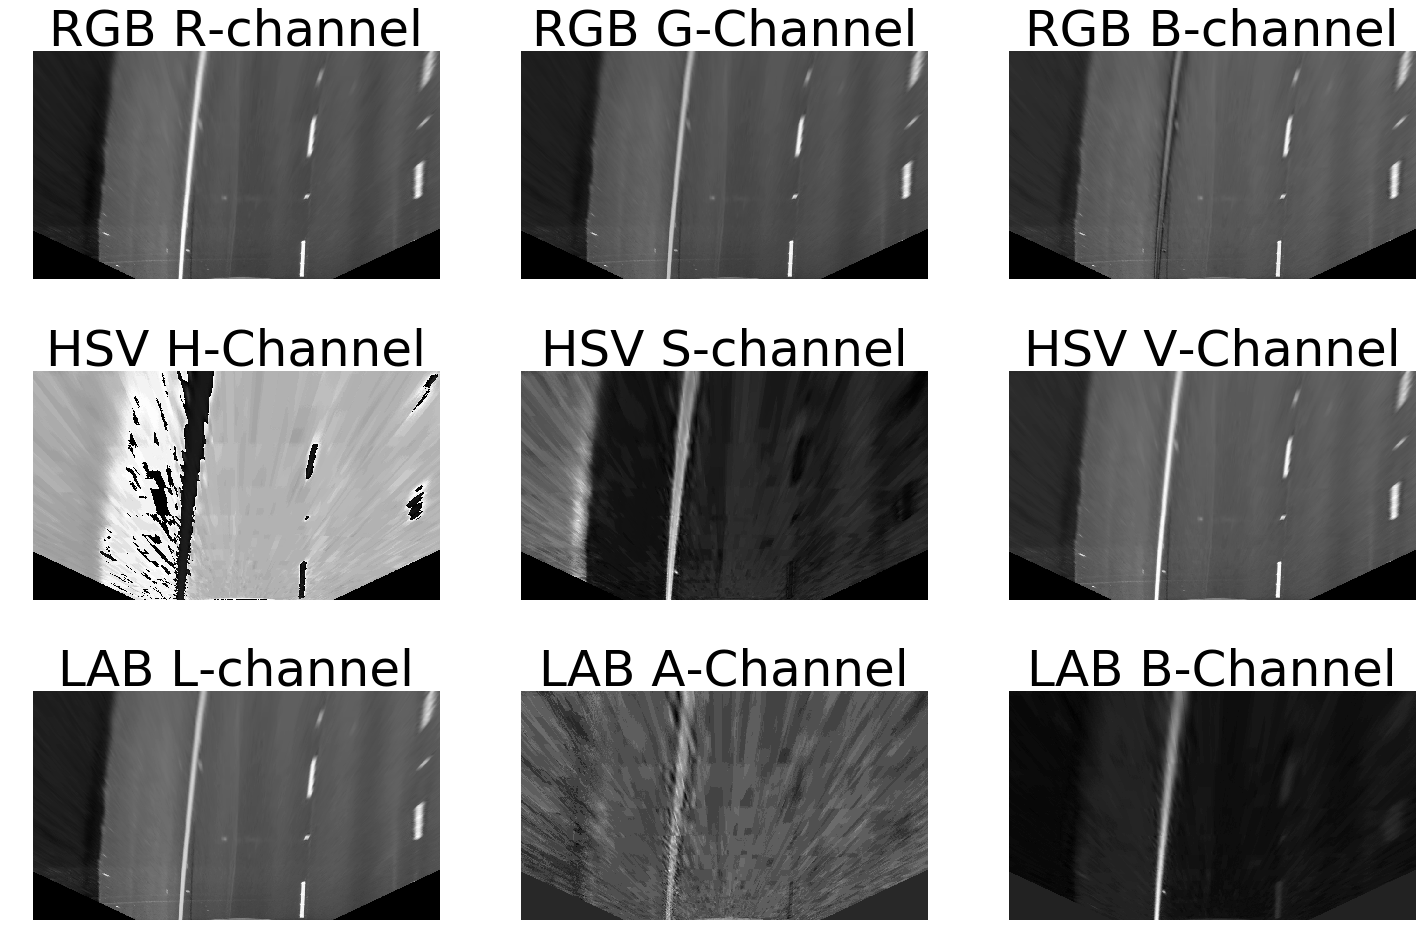

In [37]:
# Visualize multiple color space channels
exampleImg_unwarp_R = exampleImg_unwarp[:,:,0]
exampleImg_unwarp_G = exampleImg_unwarp[:,:,1]
exampleImg_unwarp_B = exampleImg_unwarp[:,:,2]
exampleImg_unwarp_HSV = cv2.cvtColor(exampleImg_unwarp, cv2.COLOR_RGB2HSV)
exampleImg_unwarp_H = exampleImg_unwarp_HSV[:,:,0]
exampleImg_unwarp_S = exampleImg_unwarp_HSV[:,:,1]
exampleImg_unwarp_V = exampleImg_unwarp_HSV[:,:,2]
exampleImg_unwarp_LAB = cv2.cvtColor(exampleImg_unwarp, cv2.COLOR_RGB2Lab)
exampleImg_unwarp_L = exampleImg_unwarp_LAB[:,:,0]
exampleImg_unwarp_A = exampleImg_unwarp_LAB[:,:,1]
exampleImg_unwarp_B2 = exampleImg_unwarp_LAB[:,:,2]
fig, axs = plt.subplots(3,3, figsize=(24, 14))
f.tight_layout()
axs = axs.ravel()
axs[0].imshow(exampleImg_unwarp_R, cmap='gray')
axs[0].set_title('RGB R-channel', fontsize=50)
axs[0].axis('off')
axs[1].imshow(exampleImg_unwarp_G, cmap='gray')
axs[1].set_title('RGB G-Channel', fontsize=50)
axs[1].axis('off')
axs[2].imshow(exampleImg_unwarp_B, cmap='gray')
axs[2].set_title('RGB B-channel', fontsize=50)
axs[2].axis('off')
axs[3].imshow(exampleImg_unwarp_H, cmap='gray')
axs[3].set_title('HSV H-Channel', fontsize=50)
axs[3].axis('off')
axs[4].imshow(exampleImg_unwarp_S, cmap='gray')
axs[4].set_title('HSV S-channel', fontsize=50)
axs[4].axis('off')
axs[5].imshow(exampleImg_unwarp_V, cmap='gray')
axs[5].set_title('HSV V-Channel', fontsize=50)
axs[5].axis('off')
axs[6].imshow(exampleImg_unwarp_L, cmap='gray')
axs[6].set_title('LAB L-channel', fontsize=50)
axs[6].axis('off')
axs[7].imshow(exampleImg_unwarp_A, cmap='gray')
axs[7].set_title('LAB A-Channel', fontsize=50)
axs[7].axis('off')
axs[8].imshow(exampleImg_unwarp_B2, cmap='gray')
axs[8].set_title('LAB B-Channel', fontsize=50)
axs[8].axis('off')
plt.subplots_adjust(left=0., right=0.8, top=0.9, bottom=0.)

### Sobel Threshold
[sobel_operator.ipynb](https://github.com/jeongwhanchoi/techniques-for-lane-finding/blob/master/sobel_operator.ipynb)

In [44]:
# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(img, orient='x', thresh_min=25, thresh_max=255):
    # Convert to grayscale or LAB L Channel
    gray = (cv2.cvtColor(img, cv2.COLOR_RGB2LAB))[:,:,0]
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

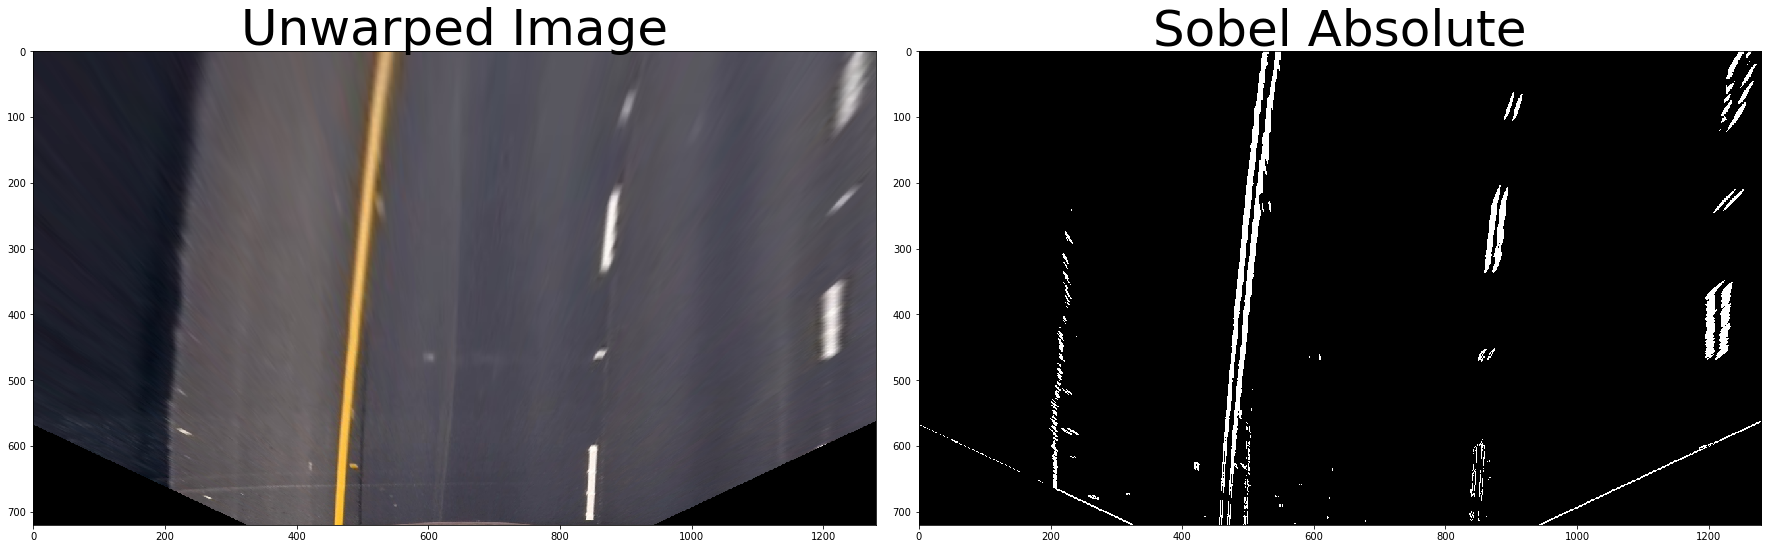

In [47]:
def update(min_thresh, max_thresh):
    exampleImg_sobelAbs = abs_sobel_thresh(exampleImg_unwarp, 'x', min_thresh, max_thresh)
    # Visualize sobel absolute threshold
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,14))
    f.tight_layout()
    ax1.imshow(exampleImg_unwarp)
    ax1.set_title('Unwarped Image', fontsize=50)
    ax2.imshow(exampleImg_sobelAbs, cmap='gray')
    ax2.set_title('Sobel Absolute', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

interact(update, 
         min_thresh=(0,255), 
         max_thresh=(0,255))

### Magnitude of the gradient
[magnitude_of_the_gradient.ipynb](https://github.com/jeongwhanchoi/techniques-for-lane-finding/blob/master/magnitude_of_the_gradient.ipynb)

In [48]:
# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=25, mag_thresh=(25, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

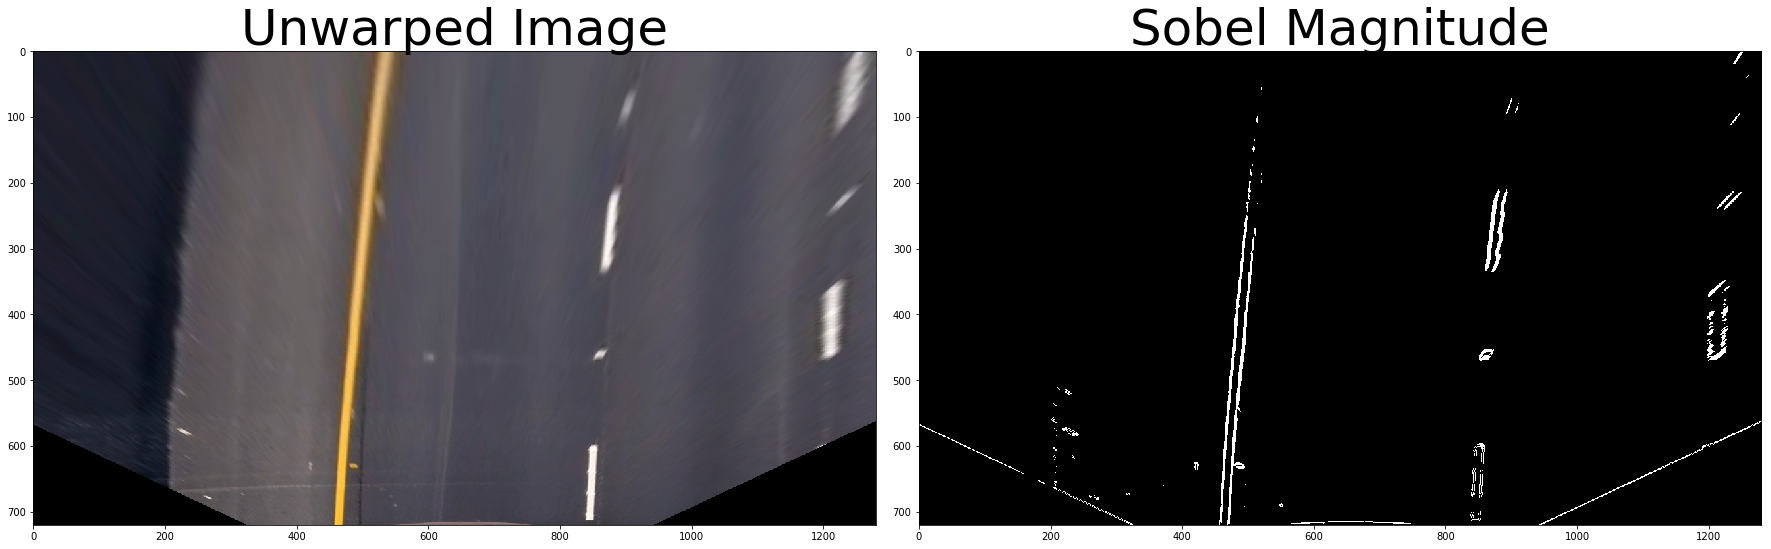

In [49]:
def update(kernel_size, min_thresh, max_thresh):
    exampleImg_sobelMag = mag_thresh(exampleImg_unwarp, kernel_size, (min_thresh, max_thresh))
    # Visualize sobel magnitude threshold
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,14))
    f.tight_layout()
    ax1.imshow(exampleImg_unwarp)
    ax1.set_title('Unwarped Image', fontsize=50)
    ax2.imshow(exampleImg_sobelMag, cmap='gray')
    ax2.set_title('Sobel Magnitude', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

interact(update, kernel_size=(1,31,2), 
                 min_thresh=(0,255), 
                 max_thresh=(0,255))

### Direction of the gradient

In [55]:
# Define a function to threshold an image for a given range and Sobel kernel
def dir_thresh(img, sobel_kernel=7, thresh=(0, 0.09)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

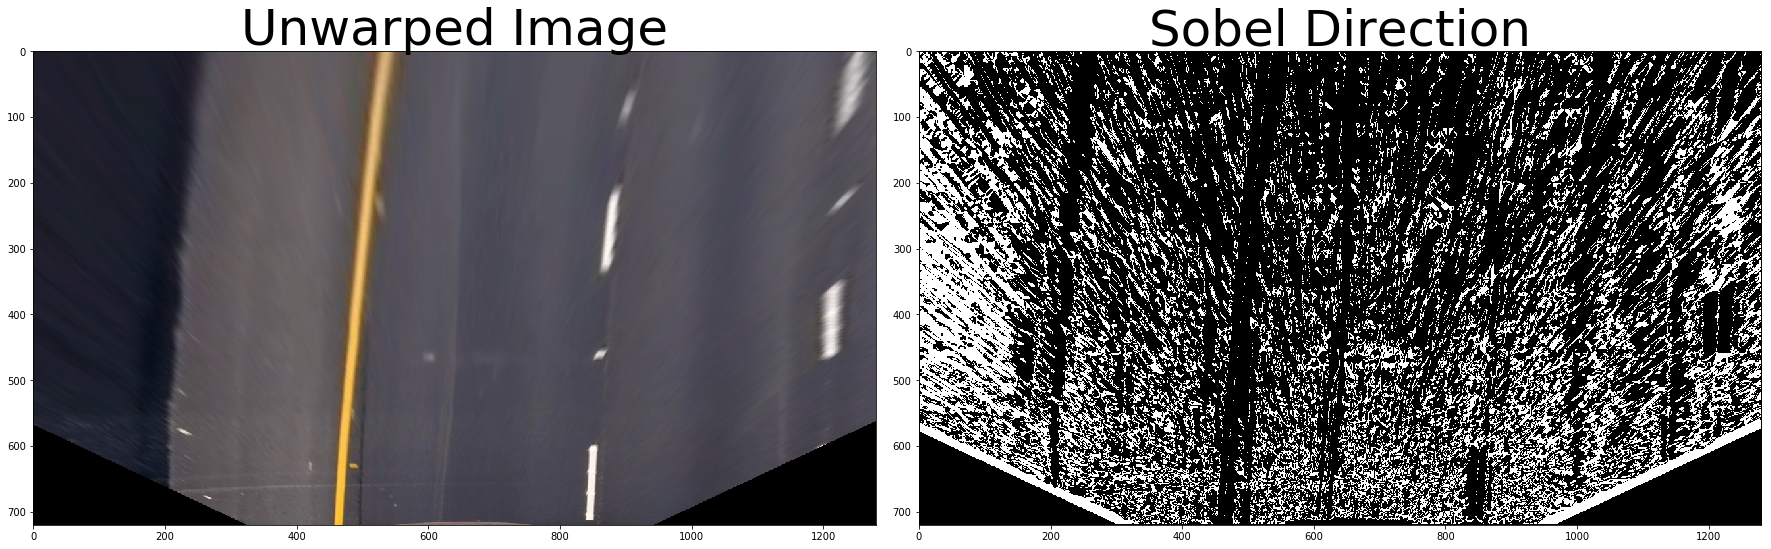

In [56]:
def update(kernel_size, min_thresh, max_thresh):
    exampleImg_sobelDir = dir_thresh(exampleImg_unwarp, kernel_size, (min_thresh, max_thresh))
    # Visualize sobel direction threshold
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,14))
    f.tight_layout()
    ax1.imshow(exampleImg_unwarp)
    ax1.set_title('Unwarped Image', fontsize=50)
    ax2.imshow(exampleImg_sobelDir, cmap='gray')
    ax2.set_title('Sobel Direction', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
interact(update, kernel_size=(1,31,2), 
                 min_thresh=(0,np.pi/2,0.01), 
                 max_thresh=(0,np.pi/2,0.01))

### Magnitude + Direction of the gradient

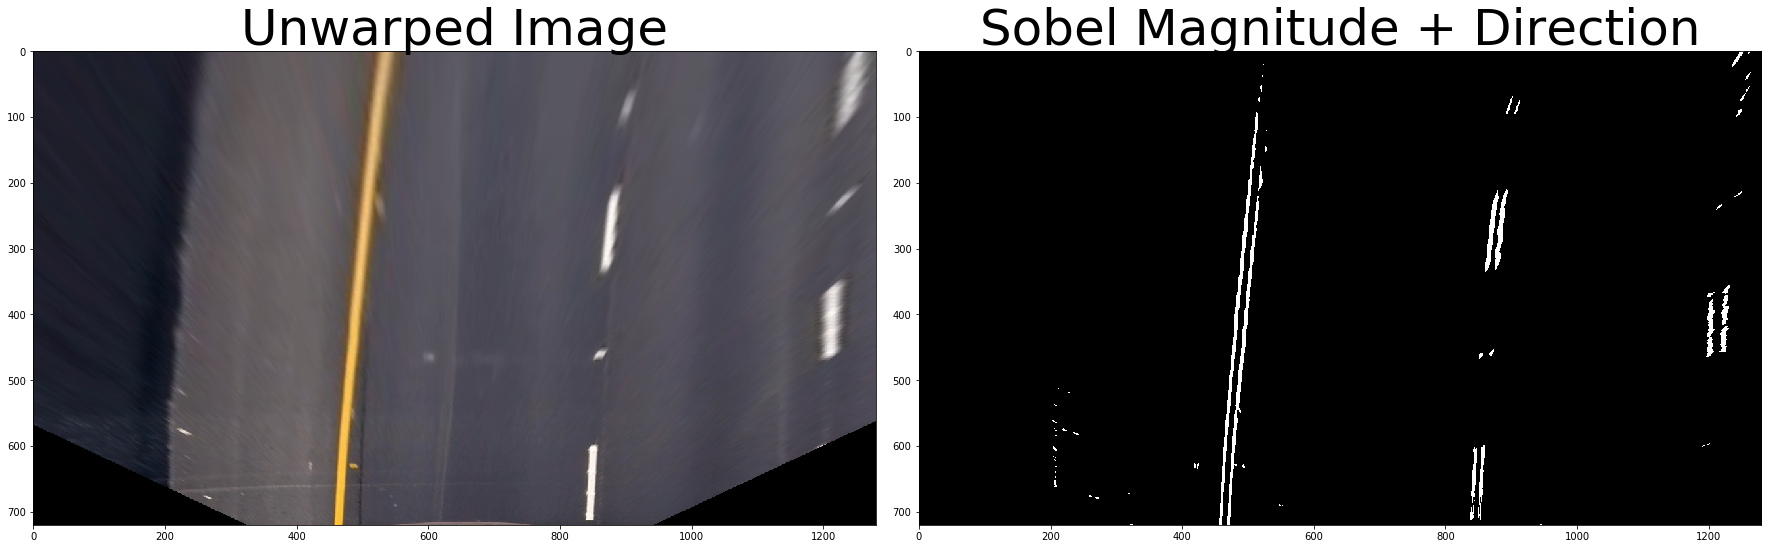

In [57]:
def update(mag_kernel_size, mag_min_thresh, mag_max_thresh, dir_kernel_size, dir_min_thresh, dir_max_thresh):
    exampleImg_sobelMag2 = mag_thresh(exampleImg_unwarp, mag_kernel_size, (mag_min_thresh, mag_max_thresh))
    exampleImg_sobelDir2 = dir_thresh(exampleImg_unwarp, dir_kernel_size, (dir_min_thresh, dir_max_thresh))
    combined = np.zeros_like(exampleImg_sobelMag2)
    combined[((exampleImg_sobelMag2 == 1) & (exampleImg_sobelDir2 == 1))] = 1
    # Visualize sobel magnitude + direction threshold
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,14))
    f.tight_layout()
    ax1.imshow(exampleImg_unwarp)
    ax1.set_title('Unwarped Image', fontsize=50)
    ax2.imshow(combined, cmap='gray')
    ax2.set_title('Sobel Magnitude + Direction', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

interact(update, mag_kernel_size=(1,31,2), 
                 mag_min_thresh=(0,255), 
                 mag_max_thresh=(0,255),
                 dir_kernel_size=(1,31,2), 
                 dir_min_thresh=(0,np.pi/2,0.01), 
                 dir_max_thresh=(0,np.pi/2,0.01))

### HLS S-Channel Threshold

In [61]:
# Define a function that thresholds the S-channel of HLS
def hls_s_thresh(img, thresh=(125, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

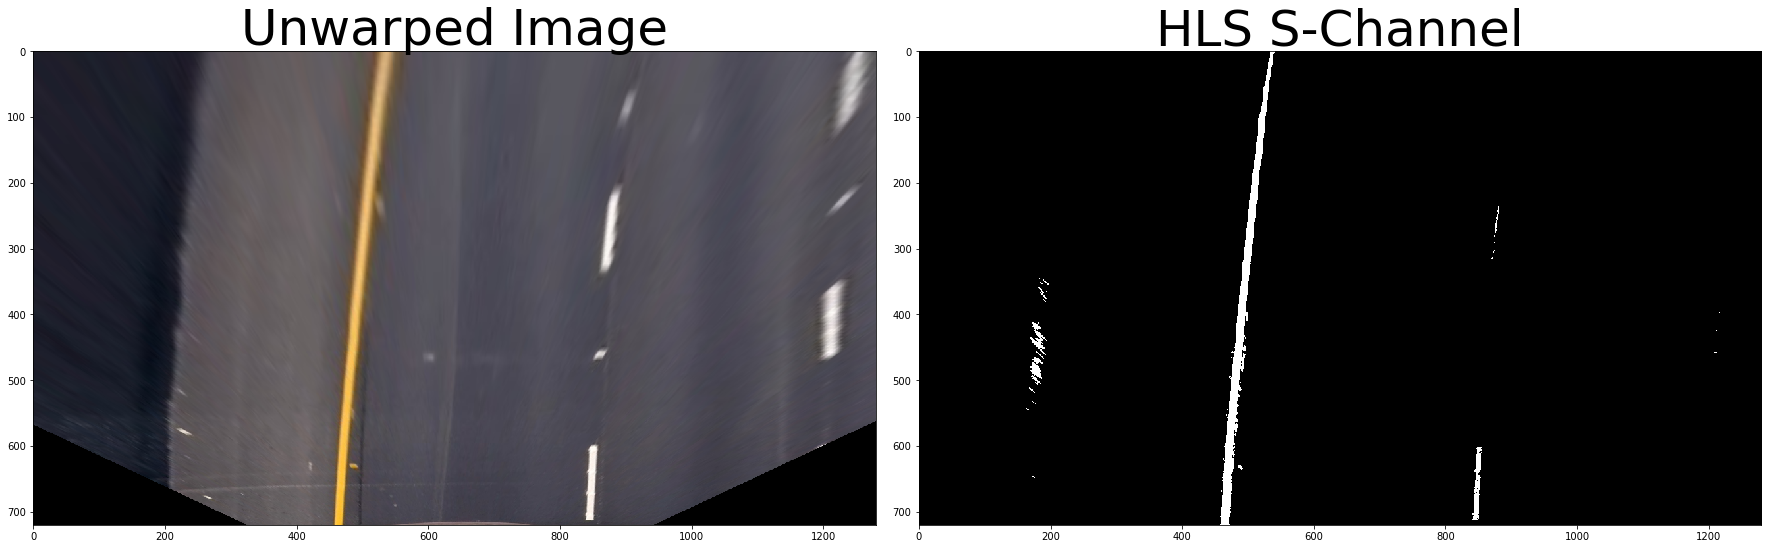

In [62]:
def update(min_thresh, max_thresh):
    exampleImg_SThresh = hls_s_thresh(exampleImg_unwarp, (min_thresh, max_thresh))
    # Visualize hls s-channel threshold
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,14))
    f.tight_layout()
    ax1.imshow(exampleImg_unwarp)
    ax1.set_title('Unwarped Image', fontsize=50)
    ax2.imshow(exampleImg_SThresh, cmap='gray')
    ax2.set_title('HLS S-Channel', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

interact(update,
         min_thresh=(0,255), 
         max_thresh=(0,255))

### HLS L-Channel Threshold

In [66]:
# Define a function that thresholds the S-channel of HLS
def hls_l_thresh(img, thresh=(220, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,1]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

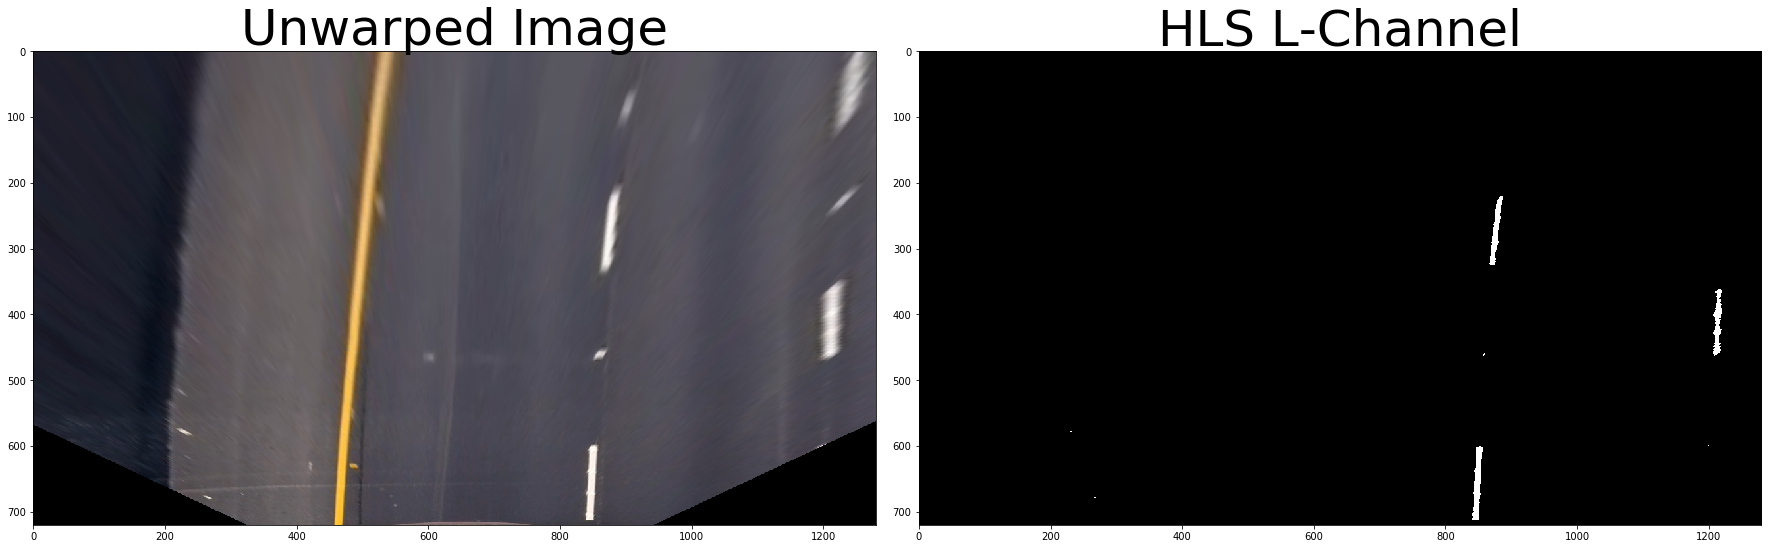

In [67]:
def update(min_thresh, max_thresh):
    exampleImg_LThresh = hls_l_thresh(exampleImg_unwarp, (min_thresh, max_thresh))
    # Visualize hls l-channel threshold
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,14))
    f.tight_layout()
    ax1.imshow(exampleImg_unwarp)
    ax1.set_title('Unwarped Image', fontsize=50)
    ax2.imshow(exampleImg_LThresh, cmap='gray')
    ax2.set_title('HLS L-Channel', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

interact(update,
         min_thresh=(0,255), 
         max_thresh=(0,255))

### LAB Colorspace

In [68]:
# Define a funtion that thresholds the B-channel of LAB
def lab_bthresh(img, thresh=(190,255)):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    lab_b = lab[:,:,2]
    if np.max(lab_b) > 175:
        lab_b = lab_b*(255/np.max(lab_b))
    binary_output = np.zeros_like(lab_b)
    binary_output[((lab_b > thresh[0]) & (lab_b <= thresh[1]))] = 1
    return binary_output

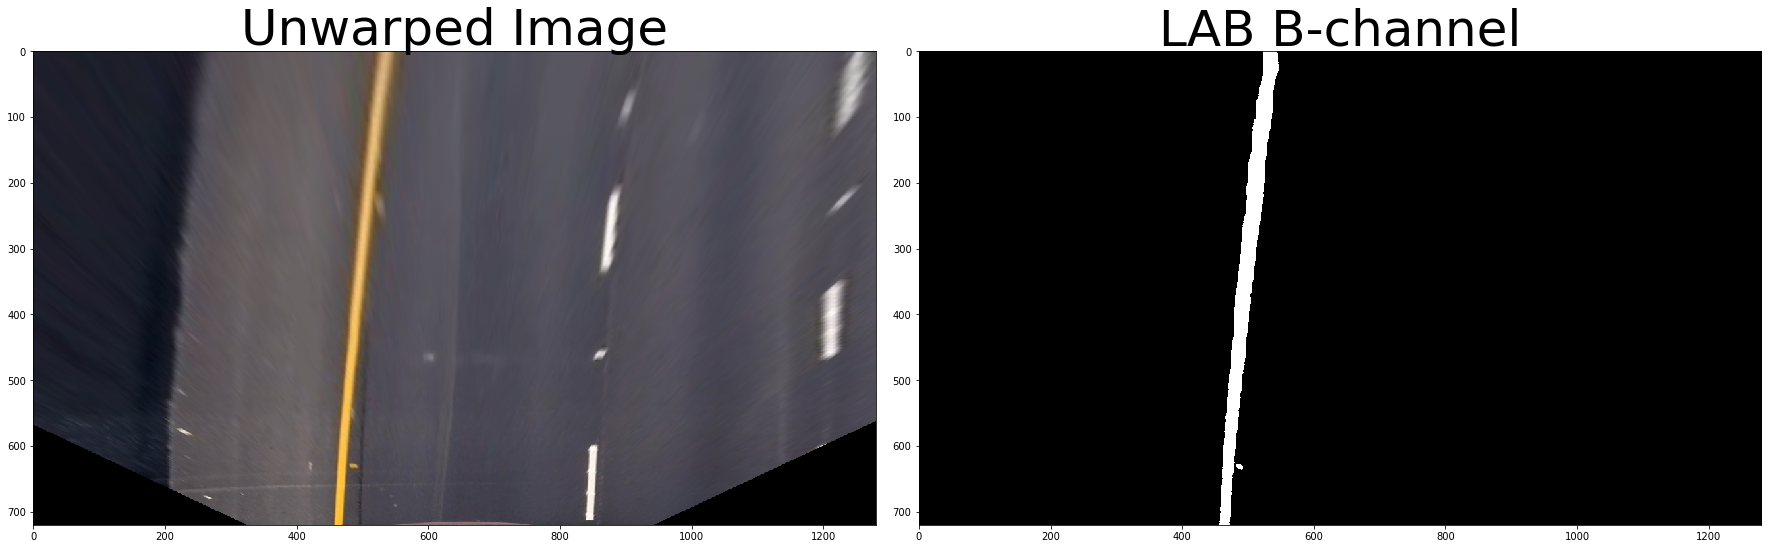

In [69]:
def update(min_b_thresh, max_b_thresh):
    exampleImg_LBThresh = lab_bthresh(exampleImg_unwarp, (min_b_thresh, max_b_thresh))
    # Visualize LAB B threshold
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,14))
    f.tight_layout()
    ax1.imshow(exampleImg_unwarp)
    ax1.set_title('Unwarped Image', fontsize=50)
    ax2.imshow(exampleImg_LBThresh, cmap='gray')
    ax2.set_title('LAB B-channel', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
interact(update,
         min_b_thresh=(0,255),
         max_b_thresh=(0,255))